# Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set
import warnings
from pandas.io import gbq
#Custom Python Module with functions specifically for this project
import ChicagoDataCleaningFunctions as cd
#Custom Python Module to fetch the data
import FetchChicagoData as fc

# Get the Data

In [2]:
%%time
#Specify input values for fetching the data
query = """
            SELECT unique_key, date, primary_type, location_description, 
                    arrest, domestic, community_area, year
            FROM `gdac-327115.Chicago.chicago2`
            WHERE year >= 2011
        """
project_id = "gdac-327115"
excel_file = "ChicagoCommunityAreas.xlsx"

#Fetch the data
chicago = fc.fetch_chicago_data(query, project_id, excel_file, verbose=True)

Fetching Chicago Data Started...

Successfully queried Google BigQuery.
Sucessfully read in excel file.
Sucessfully joined Chicago districts to main data.
Successfully dropped duplicate column

Succcessfully fetched Chicago Data
Wall time: 3min 31s


# Split the Data in Training and Test Sets

In [7]:
chicago_train = chicago.loc[chicago["year"] != 2021]
chicago_test = chicago.loc[chicago["year"] == 2021]

# Clean the Training Data

In [8]:
#Check for missing values
chicago_train.isnull().sum()

unique_key                 0
date                       0
primary_type               0
location_description    7844
arrest                     0
domestic                   0
year                       0
district_name            218
community_name           218
dtype: int64

In [9]:
%%capture --no-stdout
cd.chicago_data_cleaner(chicago_train, verbose=True)

Cleaning Started...

Successfully Cleaned Primary Type
Successfully Imputed Location
Successfully Cleaned Location
Successfully Added Month Column
Successfully Added Hour Column
Successfully Cleaned Community

Data Set Successfully Cleaned!


In [10]:
#Check to make sure the values were cleaned up
chicago_train.isnull().sum()

unique_key              0
date                    0
primary_type            0
location_description    0
arrest                  0
domestic                0
year                    0
district_name           0
community_name          0
Month                   0
Hour                    0
dtype: int64

In [11]:
#Check the dimensions
chicago_train.shape

(2814636, 11)

In [12]:
#Check the first few rows
chicago_train.head()

unique_key                      date                      primary_type  \
0    10225218 2015-09-05 23:00:00+00:00                           ROBBERY   
1    10341077 2015-12-10 05:15:00+00:00                          BURGLARY   
2    11861007 2019-10-14 22:47:00+00:00                     OTHER OFFENSE   
3    10599541 2016-07-15 22:30:00+00:00  INTERFERENCE WITH PUBLIC OFFICER   
4    10707134 2016-10-04 17:00:00+00:00                DECEPTIVE PRACTICE   

  location_description  arrest  domestic  year  district_name community_name  \
0                  CTA   False     False  2015  Far Southeast      RIVERDALE   
1            RESIDENCE   False     False  2015  Far Southeast      RIVERDALE   
2               STREET    True     False  2019  Far Southeast      RIVERDALE   
3              PARKING    True     False  2016  Far Southeast      RIVERDALE   
4               STREET   False     False  2016  Far Southeast      RIVERDALE   

   Month  Hour  
0      9    23  
1     12     5  
2     10    22  
3      7    22  
4     10    17

# Data Visualizations

The purpose of this project is to look at the percentage of crimes that result in an arrest and ultimately predict if an arrest will be made. Therefore, we are only interested in the arrest percentage broken down by each variable.

## Arrest Percentage

In [13]:
#Group by arrest while dividing by the number of rows to get the percentage
arrest_grp = (chicago_train["arrest"].value_counts() / chicago_train.shape[0]) * 100
arrest_grp = pd.DataFrame(arrest_grp).reset_index().rename(columns ={"index": "Arrest", "arrest" : "Percentage"})
arrest_grp

Arrest  Percentage
0   False   76.113217
1    True   23.886783

Text(0.5, 0, 'Arrest Status')

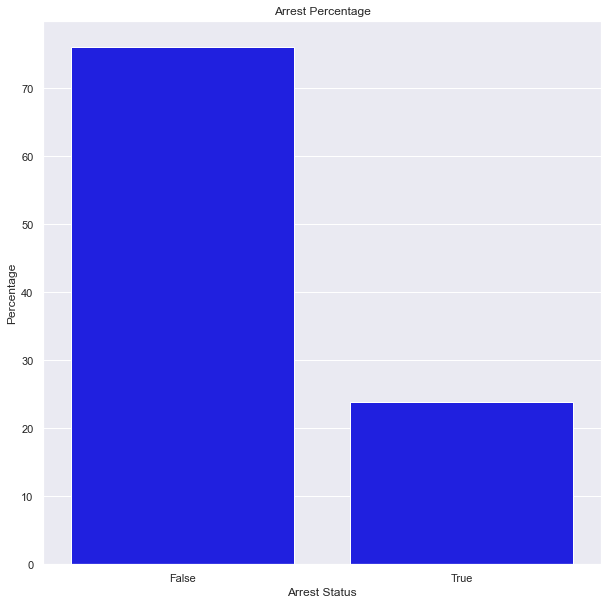

In [15]:
#Make a bar chart of the results
sns.set(rc = {'figure.figsize':(10,10)})
sns.barplot(x="Arrest", y = "Percentage", order = arrest_grp["Arrest"] \
                                            , data = arrest_grp, color = "blue")
plt.title("Arrest Percentage")
plt.ylabel("Percentage")
plt.xlabel("Arrest Status")

Nearly a quarter of every crime results in an arrest. This large class imbalance will play a factor later when we start building models to predict arrest. 

## Primary Type

### Percentage of Crime Types Contributing to Arrests

In [16]:
#Create boolean for only incidents that resulted in an arrest
mask = chicago_train["arrest"] == True

#Ceate the percentages of crimes based on the filtered data set
crm_by_arrest = chicago_train.loc[mask, "primary_type"].value_counts() / chicago_train[mask].shape[0] * 100

#Put the result into a dataframe
crm_by_arrest = pd.DataFrame(crm_by_arrest).reset_index().rename(columns ={"index": "Crime", "primary_type" : "Percentage"})
crm_by_arrest

Crime  Percentage
0                           NARCOTICS   32.969125
1                             BATTERY   16.684912
2                               THEFT    9.946365
3                   CRIMINAL TRESPASS    6.763386
4                             ASSAULT    5.858021
5                       OTHER OFFENSE    5.134116
6                   WEAPONS VIOLATION    5.056624
7                     CRIMINAL DAMAGE    2.831513
8              PUBLIC PEACE VIOLATION    2.334879
9                  DECEPTIVE PRACTICE    2.167550
10                       PROSTITUTION    1.843897
11   INTERFERENCE WITH PUBLIC OFFICER    1.662289
12                            ROBBERY    1.483655
13                           BURGLARY    1.230653
14                MOTOR VEHICLE THEFT    1.184693
15         OFFENSE INVOLVING CHILDREN    0.565499
16                           GAMBLING    0.520581
17               LIQUOR LAW VIOLATION    0.500055
18                        SEX OFFENSE    0.341352
19                           HOMICIDE    0.326479
20            CRIMINAL SEXUAL ASSAULT    0.253448
21  CONCEALED CARRY LICENSE VIOLATION    0.096084
22                              ARSON    0.065444
23                          OBSCENITY    0.060090
24                           STALKING    0.040159
25                       INTIMIDATION    0.030789
26                         KIDNAPPING    0.026921
27                   PUBLIC INDECENCY    0.017551
28                       NON-CRIMINAL    0.002975
29                  HUMAN TRAFFICKING    0.000892

Text(0.5, 0, 'Percentage')

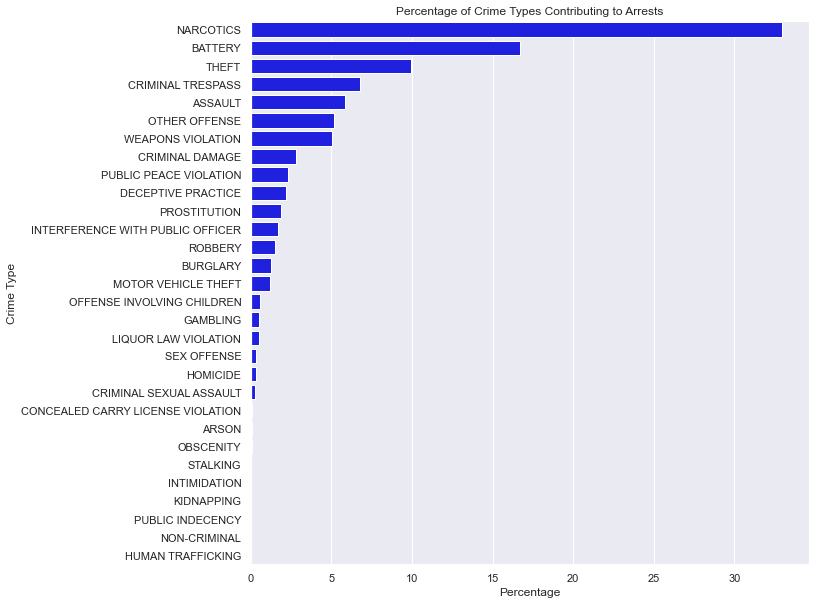

In [17]:
#Make a bar chart of the results
sns.set(rc = {'figure.figsize':(10,10)})
sns.barplot(x="Percentage", y = "Crime", order = crm_by_arrest["Crime"] \
                                            , data = crm_by_arrest, color = "blue")
plt.title("Percentage of Crime Types Contributing to Arrests")
plt.ylabel("Crime Type")
plt.xlabel("Percentage")

We see that nearly a third of all arrests made have been for Narcotics. 

### Arrest Percentage By Primary Type

In [18]:
#Group by primary type while summarizing arrest
crime_grp = chicago_train.groupby("primary_type")["arrest"].aggregate(["mean", "sum"]).sort_values(by="mean", ascending=False)
crime_grp = crime_grp.reset_index()
#Change it to a percentage
crime_grp["mean"] *= 100
crime_grp

primary_type       mean     sum
0                    PUBLIC INDECENCY      100.0     118
1                            GAMBLING  99.800399    3500
2                        PROSTITUTION  99.670365   12397
3                           NARCOTICS  99.646208  221660
4                LIQUOR LAW VIOLATION   98.67919    3362
5   CONCEALED CARRY LICENSE VIOLATION  96.706587     646
6    INTERFERENCE WITH PUBLIC OFFICER  94.768083   11176
7                           OBSCENITY  78.294574     404
8                   WEAPONS VIOLATION   74.11598   33997
9              PUBLIC PEACE VIOLATION  71.916804   15698
10                  CRIMINAL TRESPASS  64.992496   45472
11                           HOMICIDE  38.719351    2195
12                            BATTERY  21.897381  112177
13                        SEX OFFENSE  21.307214    2295
14                            ASSAULT  20.780351   39385
15                      OTHER OFFENSE  20.144615   34518
16         OFFENSE INVOLVING CHILDREN  16.277079    3802
17                           STALKING  14.697877     270
18                       INTIMIDATION   14.02439     207
19            CRIMINAL SEXUAL ASSAULT  11.474747    1704
20                              THEFT  10.515176   66872
21                              ARSON   9.817046     440
22                       NON-CRIMINAL   9.259259      20
23                            ROBBERY   9.228677    9975
24                         KIDNAPPING   9.018435     181
25                  HUMAN TRAFFICKING   8.695652       6
26                 DECEPTIVE PRACTICE   8.689767   14573
27                MOTOR VEHICLE THEFT   6.637113    7965
28                    CRIMINAL DAMAGE   6.347423   19037
29                           BURGLARY   5.425325    8274

Text(0.5, 0, 'Percentage')

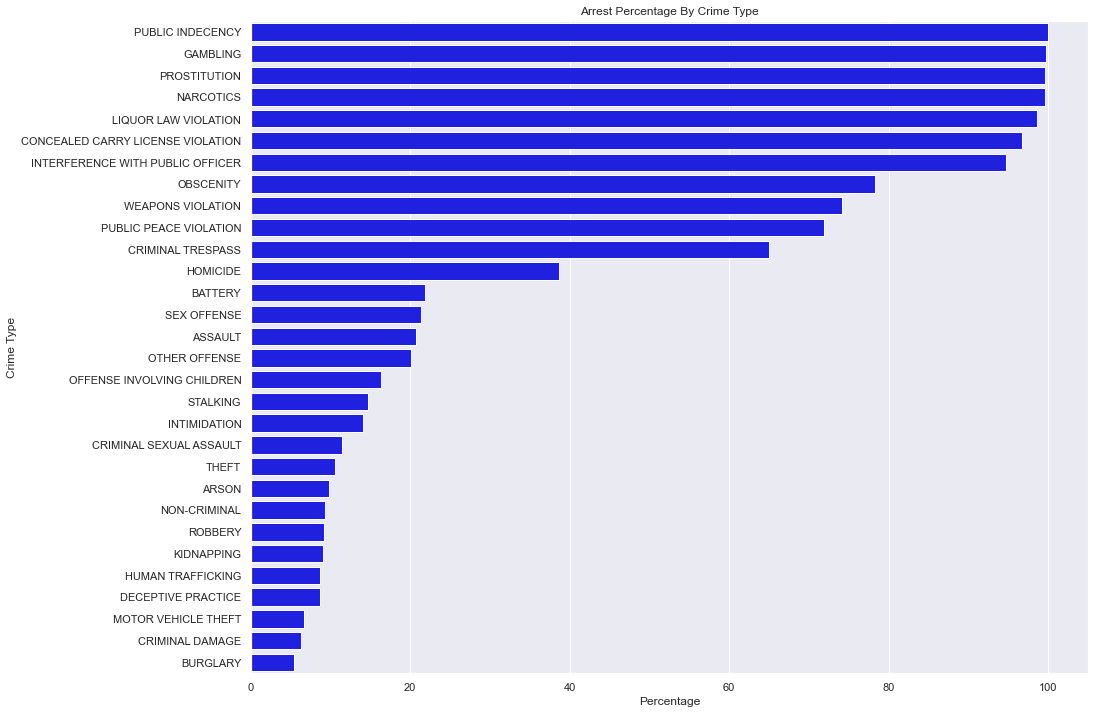

In [19]:
#Make a bar chart showing the results
sns.set(rc = {'figure.figsize':(15,12)})
sns.barplot(x="mean", y = "primary_type", order = crime_grp["primary_type"], data = crime_grp, color = "blue")
plt.title("Arrest Percentage By Crime Type")
plt.ylabel("Crime Type")
plt.xlabel("Percentage")

Interestingly, Narcotic crimes rank 4th of most occurrences and are also 4th in arrest percentage with 99.65%.

## Location Description

### Percentage of Locations Contributing to Arrests

In [20]:
#Create boolean for only incidents that resulted in an arrest
mask = chicago_train["arrest"] == True

#Ceate the percentages of locations based on the filtered data set
loc_by_arrest = chicago_train.loc[mask, "location_description"].value_counts() / chicago_train[mask].shape[0] * 100

#Put the result into a dataframe
loc_by_arrest = pd.DataFrame(loc_by_arrest).reset_index().rename(columns ={"index": "Location", "location_description" : "Percentage"})
loc_by_arrest

Location  Percentage
0              STREET   23.071546
1            SIDEWALK   18.982458
2           RESIDENCE   12.470885
3               STORE    9.917213
4           APARTMENT    8.648632
5               ALLEY    3.716203
6             PARKING    3.099835
7              SCHOOL    2.551887
8             VEHICLE    2.546235
9                 CTA    2.475585
10              OTHER    2.261849
11         RESTAURANT    1.966308
12        GAS STATION    1.801953
13      PARK PROPERTY    1.021528
14             POLICE    1.003234
15           BUILDING    0.907298
16             VACANT    0.577696
17            AIRPORT    0.486520
18           HOSPITAL    0.464507
19              HOTEL    0.457070
20                CHA    0.386122
21               BANK    0.328710
22             OFFICE    0.304465
23             SPORTS    0.136838
24            LIBRARY    0.120775
25            COLLEGE    0.107240
26             CHURCH    0.101439
27  CONSTRUCTION SITE    0.052951
28              WATER    0.033020

Text(0.5, 0, 'Percentage')

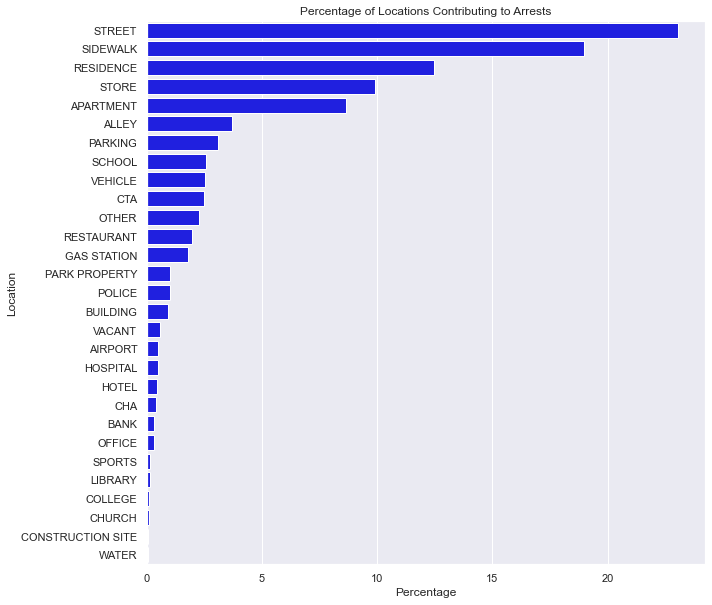

In [21]:
#Make a bar chart with the results
sns.set(rc = {'figure.figsize':(10,10)})
sns.barplot(x="Percentage", y = "Location", order = loc_by_arrest["Location"] \
                                            , data = loc_by_arrest, color = "blue")
plt.title("Percentage of Locations Contributing to Arrests")
plt.ylabel("Location")
plt.xlabel("Percentage")

The majority of arrests occur on the street. 

### Location Description By Arrest Percentage

In [22]:
#Group by location while summarizing arrest
descrip_grp = chicago_train.groupby("location_description")["arrest"].aggregate(["mean", "sum"]).sort_values(by="mean", ascending=False)
descrip_grp = descrip_grp.reset_index()
#Change to percentage
descrip_grp["mean"] *= 100
descrip_grp

location_description       mean     sum
0                POLICE  66.689737    6745
1              SIDEWALK   45.96744  127624
2                 ALLEY  42.081417   24985
3                 STORE   38.10558   66676
4              BUILDING  36.424434    6100
5           GAS STATION   36.24641   12115
6                VACANT  35.206672    3884
7               LIBRARY  32.337714     812
8         PARK PROPERTY  31.982863    6868
9               VEHICLE  29.884435   17119
10              COLLEGE  29.202106     721
11                  CTA  29.179012   16644
12               SCHOOL   26.61114   17157
13                  CHA  26.568417    2596
14              AIRPORT  25.445352    3271
15               STREET   24.25738  155116
16                HOTEL  23.629373    3073
17              PARKING  23.593674   20841
18           RESTAURANT  17.749731   13220
19             HOSPITAL  16.988522    3123
20            APARTMENT  15.861459   58147
21                WATER   13.93597     222
22                OTHER  13.717672   15207
23            RESIDENCE  13.212301   83845
24               SPORTS   12.10845     920
25               CHURCH  11.304492     682
26                 BANK  11.039512    2210
27               OFFICE  10.731886    2047
28    CONSTRUCTION SITE  10.391127     356

Text(0.5, 0, 'Percentage')

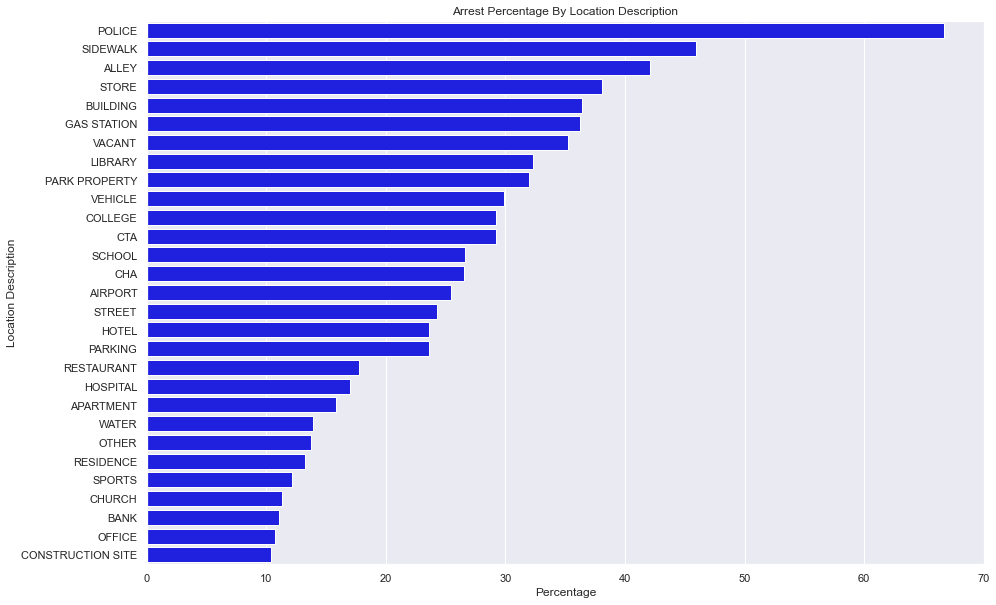

In [23]:
#Make a bar chart of the results
sns.set(rc = {'figure.figsize':(15,10)})
sns.barplot(x="mean", y = "location_description", order = descrip_grp["location_description"] \
                                            , data = descrip_grp, color = "blue")
plt.title("Arrest Percentage By Location Description")
plt.ylabel("Location Description")
plt.xlabel("Percentage")

It should be no surprise that the police location has the highest arrest percentage at 66.69%. What is surprising is that the bank location has such a low arrest percentage at only 11.04% with the numerous security measures in place.

## Month

### Percentage of Months Contributing to Arrests

In [24]:
#Create a months dict
mths_dic = {"Month" : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 
            "Month_Name": ["JAN", "FEB", "MAR", "APR", "MAY", "JUNE", "JULY", "AUG", "SEPT", "OCT", "NOV", "DEC"]}
#Create a months dataframe
mths_df = pd.DataFrame(mths_dic, columns=["Month", "Month_Name"])

#Create boolean for only incidents that resulted in an arrest
mask = chicago_train["arrest"] == True

#Ceate the percentages of months based on the filtered data set
mth_by_arrest = chicago_train.loc[mask, "Month"].value_counts() / chicago_train[mask].shape[0] * 100

#Put the result into a dataframe
mth_by_arrest = pd.DataFrame(mth_by_arrest).reset_index().rename(columns ={"index": "Month", "Month" : "Percentage"})

#Merge with mths_df to make it easier to know which month is which
mth_by_arrest = pd.merge(mth_by_arrest, mths_df).drop("Month", axis = 1).rename(columns={"Month_Name":"Month"})
mth_by_arrest[["Month", "Percentage"]]

Month  Percentage
0   JULY    9.084730
1    MAY    9.014823
2    AUG    8.941942
3    MAR    8.885273
4   JUNE    8.711399
5    JAN    8.402025
6   SEPT    8.305346
7    APR    8.248231
8    OCT    8.093693
9    FEB    7.797259
10   NOV    7.458138
11   DEC    7.057142

Text(0.5, 0, 'Percentage')

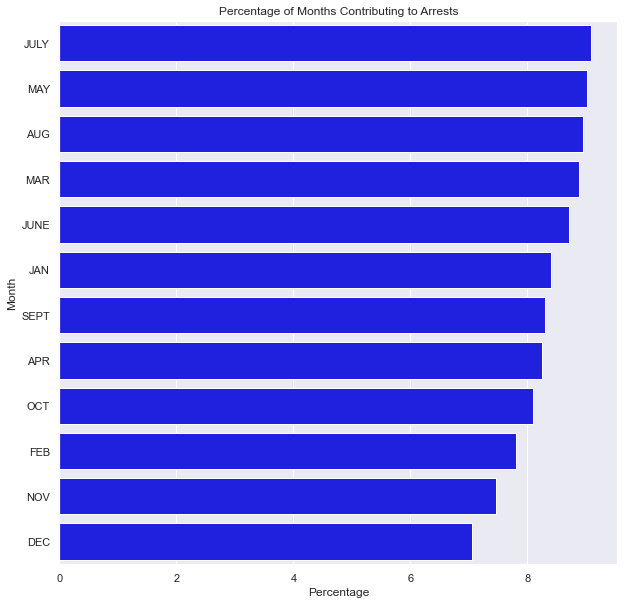

In [25]:
#Make a bar chart with the results
sns.set(rc = {'figure.figsize':(10,10)})
sns.barplot(x="Percentage", y = "Month", order = mth_by_arrest["Month"] \
                                            , data = mth_by_arrest, color = "blue")
plt.title("Percentage of Months Contributing to Arrests")
plt.ylabel("Month")
plt.xlabel("Percentage")

We can see that the each month provides almost an equal number of arrests overall. 

### Arrest Percentage By Month

In [26]:
#Group by month while summarizing arrest
month_grp = chicago_train.groupby("Month")["arrest"].aggregate(["mean", "sum"])
month_grp = month_grp.reset_index()
month_grp = pd.merge(month_grp, mths_df).drop("Month", axis = 1).rename(columns={"Month_Name":"Month"})
#Change to percentage
month_grp["mean"] *= 100
month_grp[["Month", "mean", "sum"]]

Month       mean    sum
0    JAN  25.346166  56489
1    FEB  27.038472  52423
2    MAR   26.31062  59738
3    APR  24.718405  55455
4    MAY  24.135185  60609
5   JUNE  23.172975  58569
6   JULY  23.132918  61079
7    AUG  23.004397  60119
8   SEPT  23.168652  55839
9    OCT   22.63928  54416
10   NOV  22.894988  50143
11   DEC  21.879093  47447

Text(0.5, 0, 'Month')

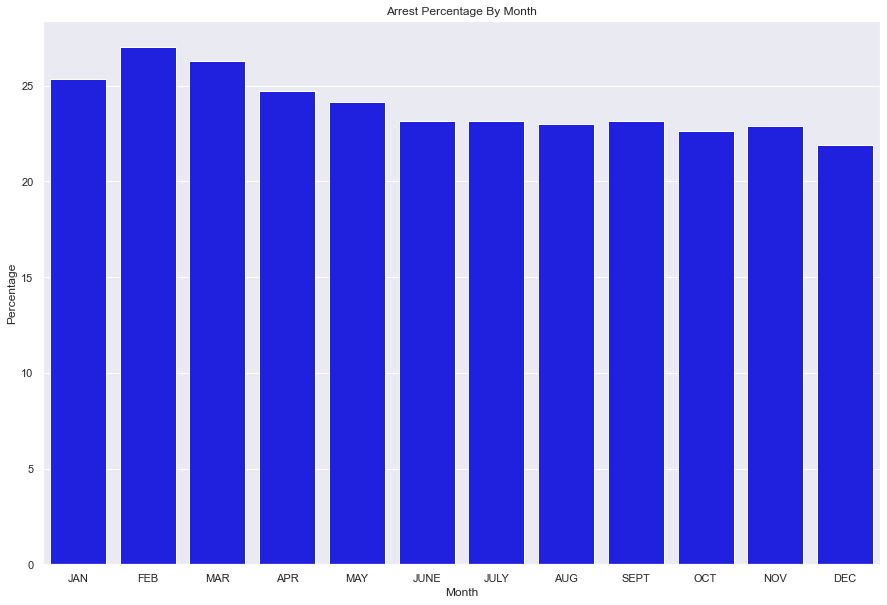

In [27]:
#Make a bar chart of the results
sns.set(rc = {'figure.figsize':(15,10)})
sns.barplot(x="Month", y = "mean", order = month_grp["Month"] \
                                            , data = month_grp, color = "blue")
plt.title("Arrest Percentage By Month")
plt.ylabel("Percentage")
plt.xlabel("Month")

We see that the first few months have the highest arrest percentage compared to the end of the year.

## Hour 

### Percentage of Hours Contributing to Arrests

In [28]:
#Create boolean for only incidents that resulted in an arrest
mask = chicago_train["arrest"] == True

#Ceate the percentages of hours based on the filtered data set
hr_by_arrest = chicago_train.loc[mask, "Hour"].value_counts() / chicago_train[mask].shape[0] * 100

#Put the result into a dataframe
hr_by_arrest = pd.DataFrame(hr_by_arrest).reset_index().rename(columns ={"index": "Hour", "Hour" : "Percentage"})
#Change the Hour to a string type
hr_by_arrest["Hour"] = hr_by_arrest["Hour"].astype(str)
hr_by_arrest

Hour  Percentage
0    19    7.425267
1    20    6.772012
2    21    6.166949
3    18    6.048405
4    22    5.867094
5    11    5.624950
6    12    5.436797
7    15    5.347703
8    16    5.223805
9    14    5.190042
10   13    5.083695
11   17    4.998468
12   23    4.897773
13   10    4.570699
14    0    4.105151
15    9    3.103703
16    1    2.965674
17    8    2.431558
18    2    2.308255
19    3    1.684004
20    7    1.548653
21    6    1.288512
22    4    1.124901
23    5    0.785928

Text(0.5, 0, 'Percentage')

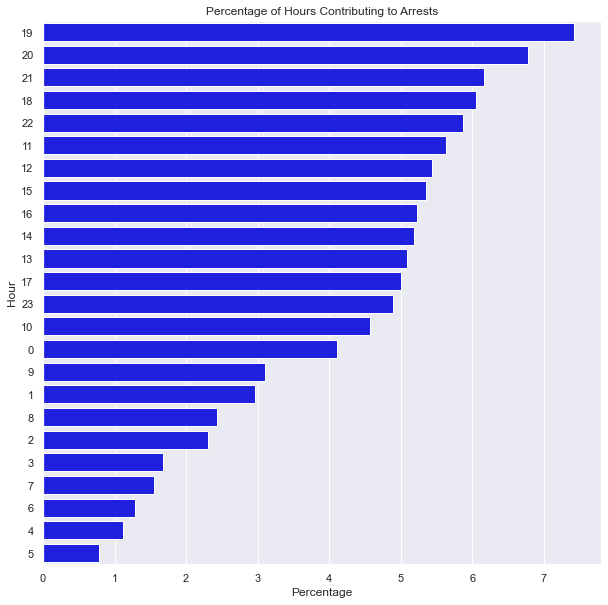

In [29]:
#Make a bar chart with the results
sns.set(rc = {'figure.figsize':(10,10)})
sns.barplot(x="Percentage", y = "Hour", order = hr_by_arrest["Hour"] \
                                            , data = hr_by_arrest, color = "blue")
plt.title("Percentage of Hours Contributing to Arrests")
plt.ylabel("Hour")
plt.xlabel("Percentage")

We can see that most of the arrests occur at 7pm with the fewest being at 5am. 

### Arrest Percentage By Hour

In [30]:
#Group by Hour while summarizing Arrest
hour_grp = chicago_train.groupby("Hour")["arrest"].aggregate(["mean", "sum"])
hour_grp = hour_grp.reset_index()
#Change to a percentage
hour_grp["mean"] *= 100
hour_grp

Hour       mean    sum
0      0  19.375899  27600
1      1  23.391051  19939
2      2  21.270268  15519
3      3  18.817624  11322
4      4  16.385735   7563
5      5  13.201419   5284
6      6  18.085595   8663
7      7  15.620968  10412
8      8  16.594596  16348
9      9  16.002546  20867
10    10  24.500893  30730
11    11  29.152213  37818
12    12  21.991529  36553
13    13  25.321529  34179
14    14  24.328413  34894
15    15  23.301663  35954
16    16  23.751589  35121
17    17  22.662656  33606
18    18  25.750706  40665
19    19   31.16113  49922
20    20  29.737567  45530
21    21  28.862406  41462
22    22  27.769291  39446
23    23  28.141318  32929

Text(0.5, 0, 'Hour')

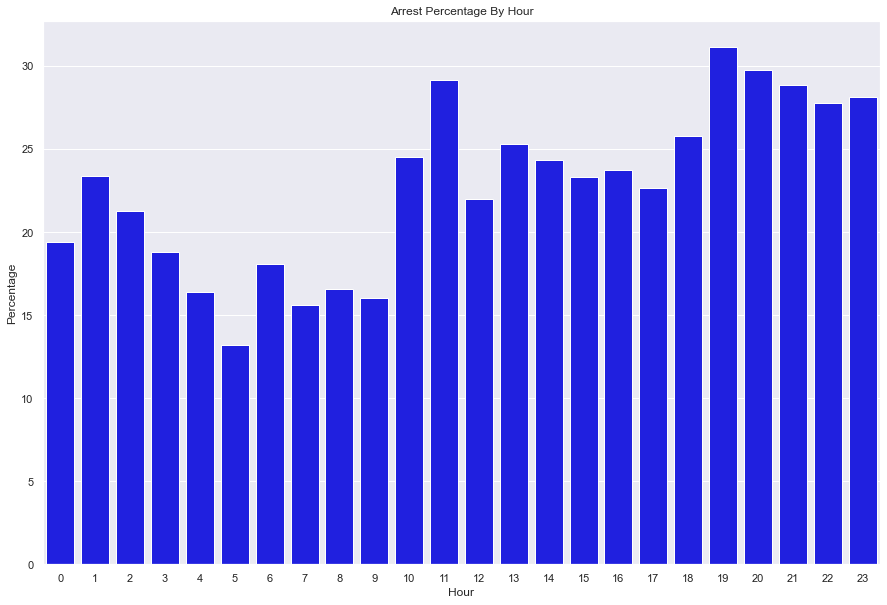

In [31]:
sns.set(rc = {'figure.figsize':(15,10)})
sns.barplot(x="Hour", y = "mean", order = hour_grp["Hour"] \
                                            , data = hour_grp, color = "blue")
plt.title("Arrest Percentage By Hour")
plt.ylabel("Percentage")
plt.xlabel("Hour")

We see that there are large discrepancies for the arrest percentage by hour of the day. Let's investigate this seeing if we can find an explanation. We'll look at the two extremes: 5am vs. 7pm. 

### Arrest Percentage By Primary Type Grouped By 5am and 7pm

In [32]:
#Make a boolean mask for the 5th hour
mask = chicago_train["Hour"] == 5

#Group by primary type while summarizing arrest
crime_grp_5 = chicago_train.loc[mask].groupby("primary_type")["arrest"].aggregate(["mean", "sum"])
crime_grp_5 = crime_grp_5.reset_index()
#Change it to a percentage
crime_grp_5["mean"] *= 100
#Add an Hour column
crime_grp_5["Hour"] = "5am"

#Make a boolean mask for the 19th hour
mask = chicago_train["Hour"] == 19

#Group by primary type while summarizing arrest
crime_grp_19 = chicago_train.loc[mask].groupby("primary_type")["arrest"].aggregate(["mean", "sum"])
crime_grp_19 = crime_grp_19.reset_index()
#Change it to a percentage
crime_grp_19["mean"] *= 100
crime_grp_19["Hour"] = "7pm"

#Concat the two data frames
crime_grp_hour = pd.concat([crime_grp_5, crime_grp_19])
#Sort by arrest percentage
crime_grp_hour.sort_values(by="mean", ascending = False, inplace=True)

Text(0.5, 0, 'Percentage')

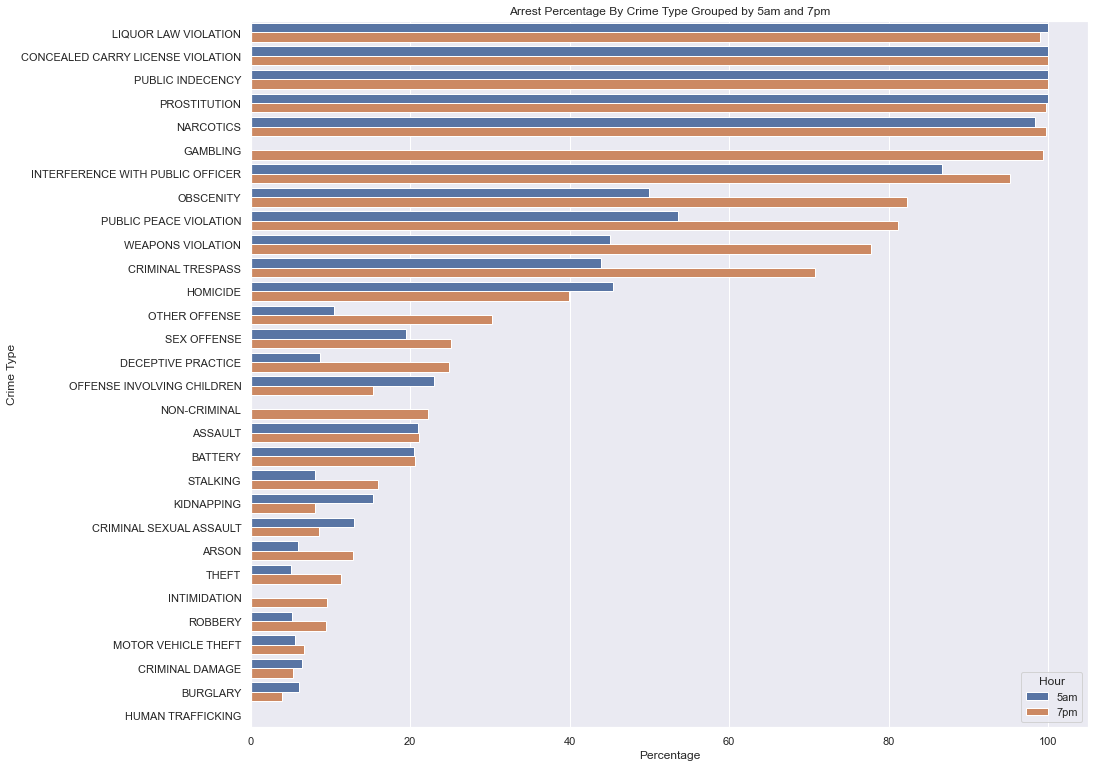

In [33]:
#Make a bar chart showing the results
sns.set(rc = {'figure.figsize':(15,13)})
sns.barplot(x="mean", y = "primary_type", data = crime_grp_hour, hue = "Hour")
plt.title("Arrest Percentage By Crime Type Grouped by 5am and 7pm")
plt.ylabel("Crime Type")
plt.xlabel("Percentage")

### Arrest Percentage By Location Grouped By 5am and 7pm

In [34]:
#Make a boolean mask for the 5th hour
mask = chicago_train["Hour"] == 5

#Group by location description while summarizing by arrest
loc_grp_5 = chicago_train.loc[mask].groupby("location_description")["arrest"].aggregate(["mean", "sum"])
loc_grp_5 = loc_grp_5.reset_index()
#Change it to a percentage
loc_grp_5["mean"] *= 100
#Add an Hour column
loc_grp_5["Hour"] = "5am"

#Make a boolean mask for the 19th hour
mask = chicago_train["Hour"] == 19

#Group by location description while summarizing by arrest
loc_grp_19 = chicago_train.loc[mask].groupby("location_description")["arrest"].aggregate(["mean", "sum"])
loc_grp_19 = loc_grp_19.reset_index()
#Change it to a percentage
loc_grp_19["mean"] *= 100
loc_grp_19["Hour"] = "7pm"

#Concat the two data frames
loc_grp_hour = pd.concat([loc_grp_5, loc_grp_19])
#Sort by arrest percentage
loc_grp_hour.sort_values(by="mean", ascending = False, inplace=True)

Text(0.5, 0, 'Percentage')

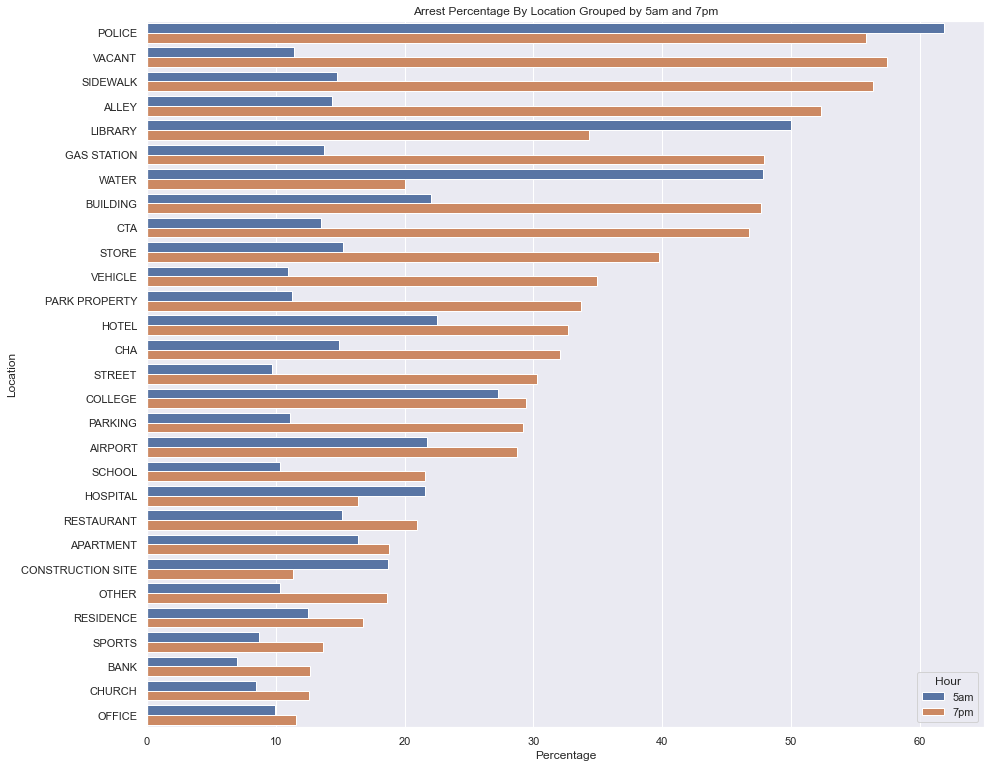

In [35]:
#Make a bar chart showing the results
sns.set(rc = {'figure.figsize':(15,13)})
sns.barplot(x="mean", y = "location_description", data = loc_grp_hour, hue = "Hour")
plt.title("Arrest Percentage By Location Grouped by 5am and 7pm")
plt.ylabel("Location")
plt.xlabel("Percentage")

It's important to correctly dissect what is happening in both of these graphs. At first glance, it may seem that 7pm simply has more occurrences of each crime or location compared to 5am. That may be true but that's not what is being shown. What is being shown is that given a crime occured at a "VACANT" location, the arrest percentage at 7pm is 57.41% compared to 11.39% for example. Therefore, for nearly every crime and location 7pm makes more arrests than 5am. This is probably because there are more officers working but the data does not provide the information to conclude that claim.  

## Districts

### Percentage of Districts Contributing to Arrests

In [36]:
#Create boolean for only incidents that resulted in an arrest
mask = chicago_train["arrest"] == True

#Ceate the percentages of districts based on the filtered data set
dst_by_arrest = chicago_train.loc[mask, "district_name"].value_counts() / chicago_train[mask].shape[0] * 100

#Put the result into a data set
dst_by_arrest = pd.DataFrame(dst_by_arrest).reset_index().rename(columns ={"index": "District", "district_name" : "Percentage"})
dst_by_arrest

District  Percentage
0           West   32.091723
1      Southwest   15.359513
2          South   12.283624
3  Far Southeast   12.178616
4      Far North    7.029477
5        Central    6.553666
6  Far Southwest    5.791833
7          North    4.371540
8      Northwest    4.340008

Text(0.5, 0, 'Percentage')

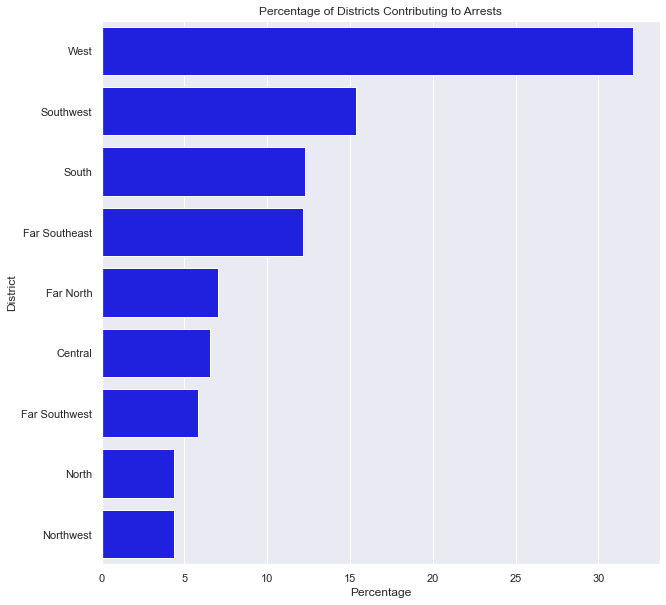

In [37]:
sns.set(rc = {'figure.figsize':(10,10)})
sns.barplot(x="Percentage", y = "District", order = dst_by_arrest["District"] \
                                            , data = dst_by_arrest, color = "blue")
plt.title("Percentage of Districts Contributing to Arrests")
plt.ylabel("District")
plt.xlabel("Percentage")

Nearly a third of all arrests occur in the West District

### Arrest Percentage By Districts

In [38]:
#Group by district while summarizing arrest
district_grp = chicago_train.groupby("district_name")["arrest"].aggregate(["mean", "sum"]).sort_values(by="mean", ascending = False)
district_grp = district_grp.reset_index()
#Change to a percentage
district_grp["mean"] *= 100
district_grp

district_name       mean     sum
0           West  30.380059  215761
1      Southwest   25.64398  103266
2  Far Southeast  24.422617   81880
3          South  21.928145   82586
4  Far Southwest  21.829679   38940
5        Central  21.049866   44062
6      Far North  19.157742   47261
7      Northwest  18.663929   29179
8          North   14.76052   29391

Text(0.5, 0, 'District')

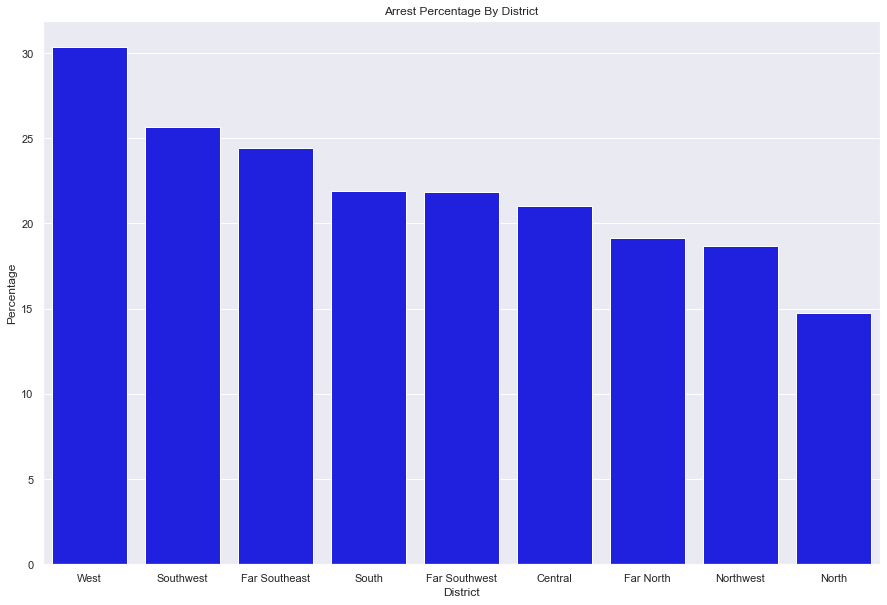

In [39]:
#Make a bar chart with the results
sns.set(rc = {'figure.figsize':(15,10)})
sns.barplot(x="district_name", y = "mean", order = district_grp["district_name"] \
                                            , data = district_grp, color = "blue")
plt.title("Arrest Percentage By District")
plt.ylabel("Percentage")
plt.xlabel("District")

Again, we see a fairly large discrepancy between the highest district, West, compared to the lowest district, North. Let's see if we can again break this down. 

### Arrest Percentage By Primary Type Grouped By West and North Districts

In [40]:
#Make a boolean mask for the West District
mask = chicago_train["district_name"] == "West"

#Group by primary type while summarizing by arrest
crm_grp_west = chicago_train.loc[mask].groupby("primary_type")["arrest"].aggregate(["mean", "sum"])
crm_grp_west = crm_grp_west.reset_index()
#Change it to a percentage
crm_grp_west["mean"] *= 100
#Add an Hour column
crm_grp_west["District"] = "West"

#Make a boolean mask for the North District
mask = chicago_train["district_name"] == "North"

#Group by primary type while summarizing by arrest
crm_grp_north = chicago_train.loc[mask].groupby("primary_type")["arrest"].aggregate(["mean", "sum"])
crm_grp_north = crm_grp_north.reset_index()
#Change it to a percentage
crm_grp_north["mean"] *= 100
crm_grp_north["District"] = "North"

#Concat the two data frames
crm_grp_dst = pd.concat([crm_grp_west, crm_grp_north])
#Sort by arrest percentage
crm_grp_dst.sort_values(by="mean", ascending = False, inplace=True)

Text(0.5, 0, 'Percentage')

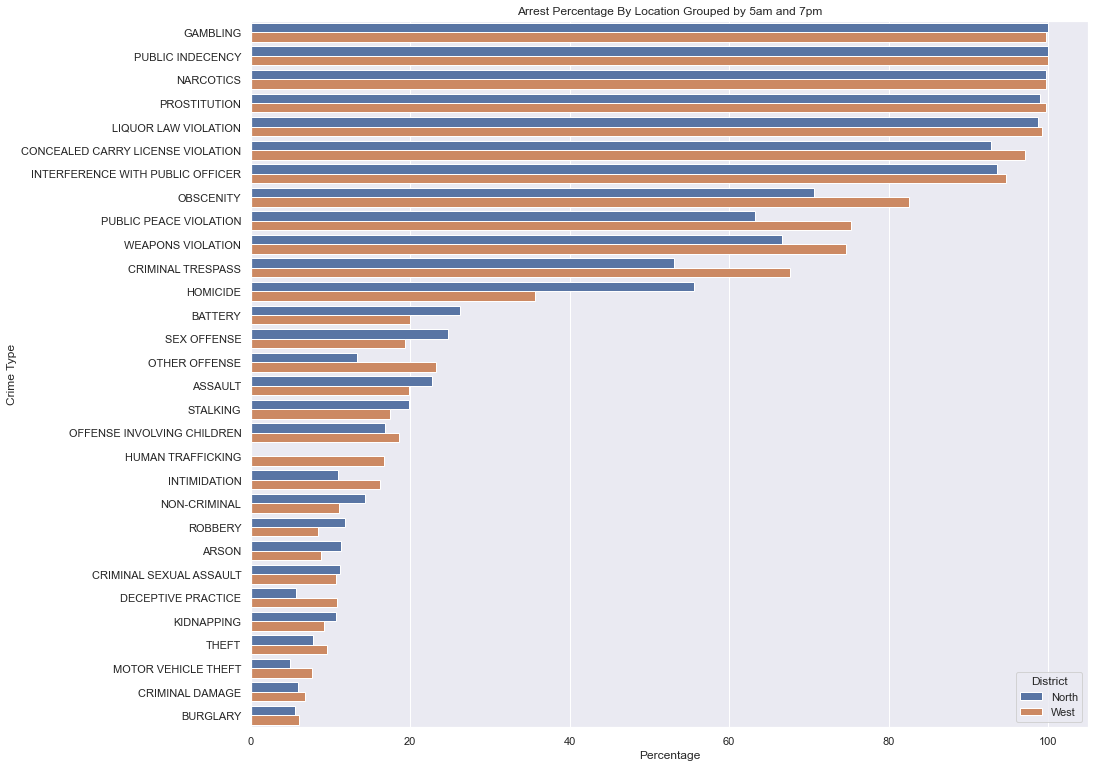

In [41]:
#Make a bar chart showing the results
sns.set(rc = {'figure.figsize':(15,13)})
sns.barplot(x="mean", y = "primary_type", data = crm_grp_dst, hue = "District")
plt.title("Arrest Percentage By Location Grouped by 5am and 7pm")
plt.ylabel("Crime Type")
plt.xlabel("Percentage")

### Arrest Percentage By Location Grouped By West and North Districts

In [42]:
#Make a boolean mask for the West District
mask = chicago_train["district_name"] == "West"

#Group by primary type while summarizing by arrest
loc_grp_west = chicago_train.loc[mask].groupby("location_description")["arrest"].aggregate(["mean", "sum"])
loc_grp_west = loc_grp_west.reset_index()
#Change it to a percentage
loc_grp_west["mean"] *= 100
#Add an Hour column
loc_grp_west["District"] = "West"

#Make a boolean mask for the North District
mask = chicago_train["district_name"] == "North"

#Group by primary type while summarizing by arrest
loc_grp_north = chicago_train.loc[mask].groupby("location_description")["arrest"].aggregate(["mean", "sum"])
loc_grp_north = loc_grp_north.reset_index()
#Change it to a percentage
loc_grp_north["mean"] *= 100
loc_grp_north["District"] = "North"

#Concat the two data frames
loc_grp_dst = pd.concat([loc_grp_west, loc_grp_north])
#Sort by arrest percentage
loc_grp_dst.sort_values(by="mean", ascending = False, inplace=True)

Text(0.5, 0, 'Percentage')

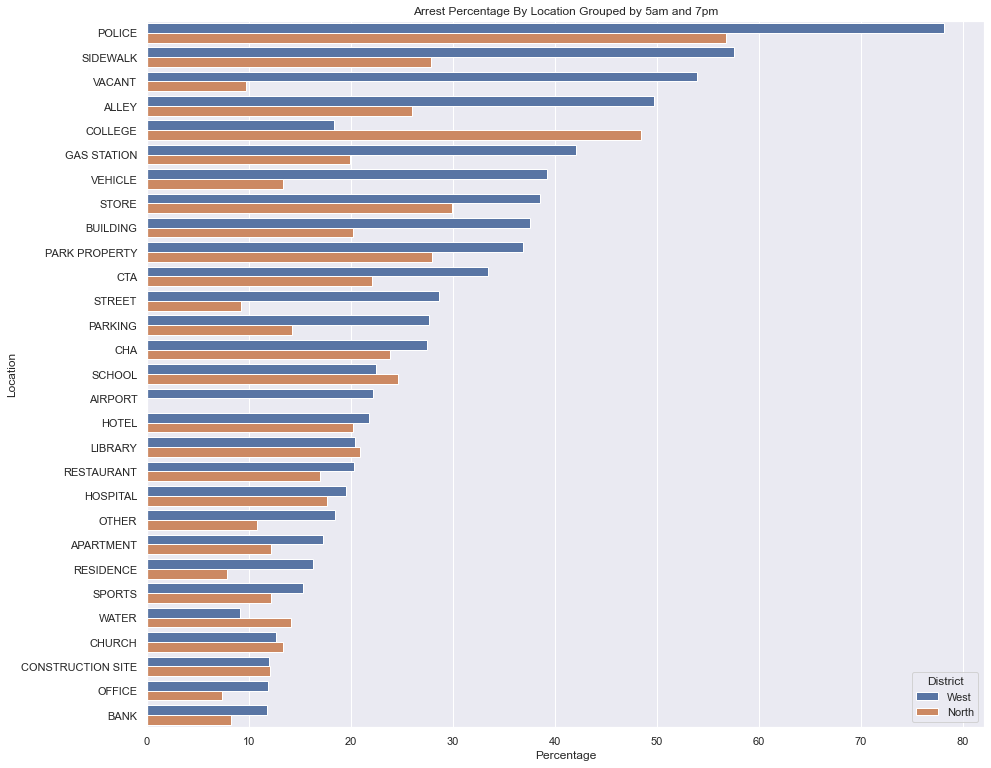

In [43]:
#Make a bar chart showing the results
sns.set(rc = {'figure.figsize':(15,13)})
sns.barplot(x="mean", y = "location_description", data = loc_grp_dst, hue = "District")
plt.title("Arrest Percentage By Location Grouped by 5am and 7pm")
plt.ylabel("Location")
plt.xlabel("Percentage")

We can see that when comparing the arrest status of crime type grouped by the West and North district there is little to no difference. However, when comparing the arrest status of location grouped by the West and North district is when the overall difference between the West and North district becomes clear. The arrest percentage of the West district for each location is higher than nearly every location of the North district. 

## Community Names

### Percentage of Community Names Contributing to Arrests

In [44]:
#Create boolean for only incidents that resulted in an arrest
mask = chicago_train["arrest"] == True

#Ceate a the percentages of crimes based on the filtered data set
cn_by_arrest = chicago_train.loc[mask, "community_name"].value_counts() / chicago_train[mask].shape[0] * 100

#Put the result into a data set
cn_by_arrest = pd.DataFrame(cn_by_arrest).reset_index().rename(columns ={"index": "Community Name", "community_name" : "Percentage"})
cn_by_arrest

Community Name  Percentage
0               AUSTIN    8.722257
1       NORTH LAWNDALE    4.958458
2        HUMBOLDT PARK    4.844525
3   WEST GARFIELD PARK    3.987798
4       WEST ENGLEWOOD    3.371727
..                 ...         ...
72           MONTCLARE    0.133864
73     MOUNT GREENWOOD    0.128955
74            BURNSIDE    0.128807
75         FOREST GLEN    0.074369
76         EDISON PARK    0.050422

[77 rows x 2 columns]

Text(0.5, 0, 'Percentage')

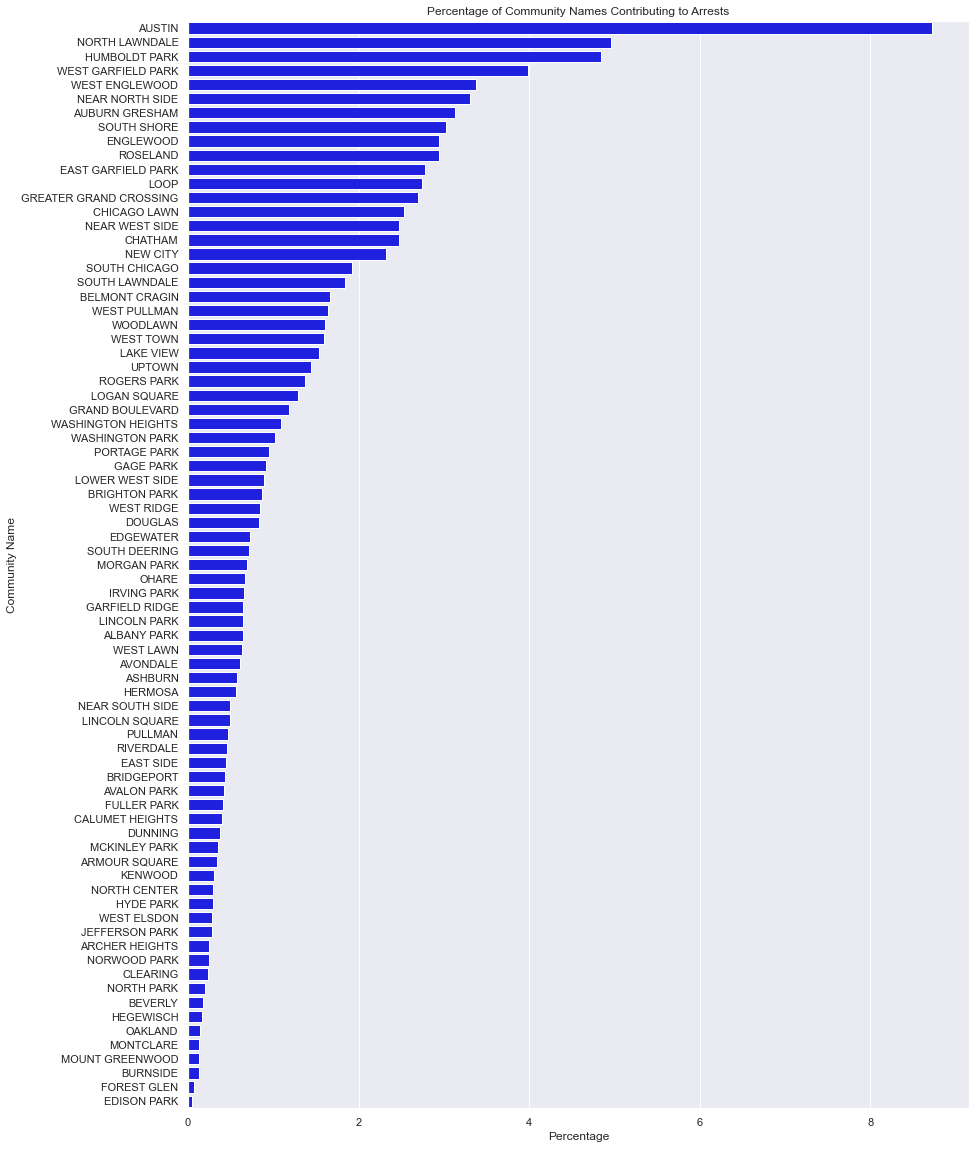

In [45]:
sns.set(rc = {'figure.figsize':(14,20)})
sns.barplot(x="Percentage", y = "Community Name", order = cn_by_arrest["Community Name"] \
                                            , data = cn_by_arrest, color = "blue")
plt.title("Percentage of Community Names Contributing to Arrests")
plt.ylabel("Community Name")
plt.xlabel("Percentage")

Austin contributes the most arrests among all community areas. 

### Arrest Percentage By Community Names

In [46]:
#Group by Community Name while summarizing Arrest
comm_grp = chicago_train.groupby("community_name")["arrest"].aggregate(["mean", "sum"]).sort_values(by="mean", ascending = False)
comm_grp = comm_grp.reset_index()
#Change to percentage
comm_grp["mean"] *= 100
#Too many to show all 
comm_grp.head()

community_name       mean    sum
0  WEST GARFIELD PARK  44.676809  26811
1      NORTH LAWNDALE  36.648161  33337
2       HUMBOLDT PARK  36.615554  32571
3  EAST GARFIELD PARK  35.035908  18685
4              AUSTIN  33.419386  58642

In [47]:
comm_grp.tail()

community_name       mean   sum
72        BEVERLY  12.093863  1206
73    EDISON PARK  11.824206   339
74      HYDE PARK  11.168098  1938
75   LINCOLN PARK   9.963261  4339
76    FOREST GLEN   9.626492   500

Text(0.5, 0, 'Percentage')

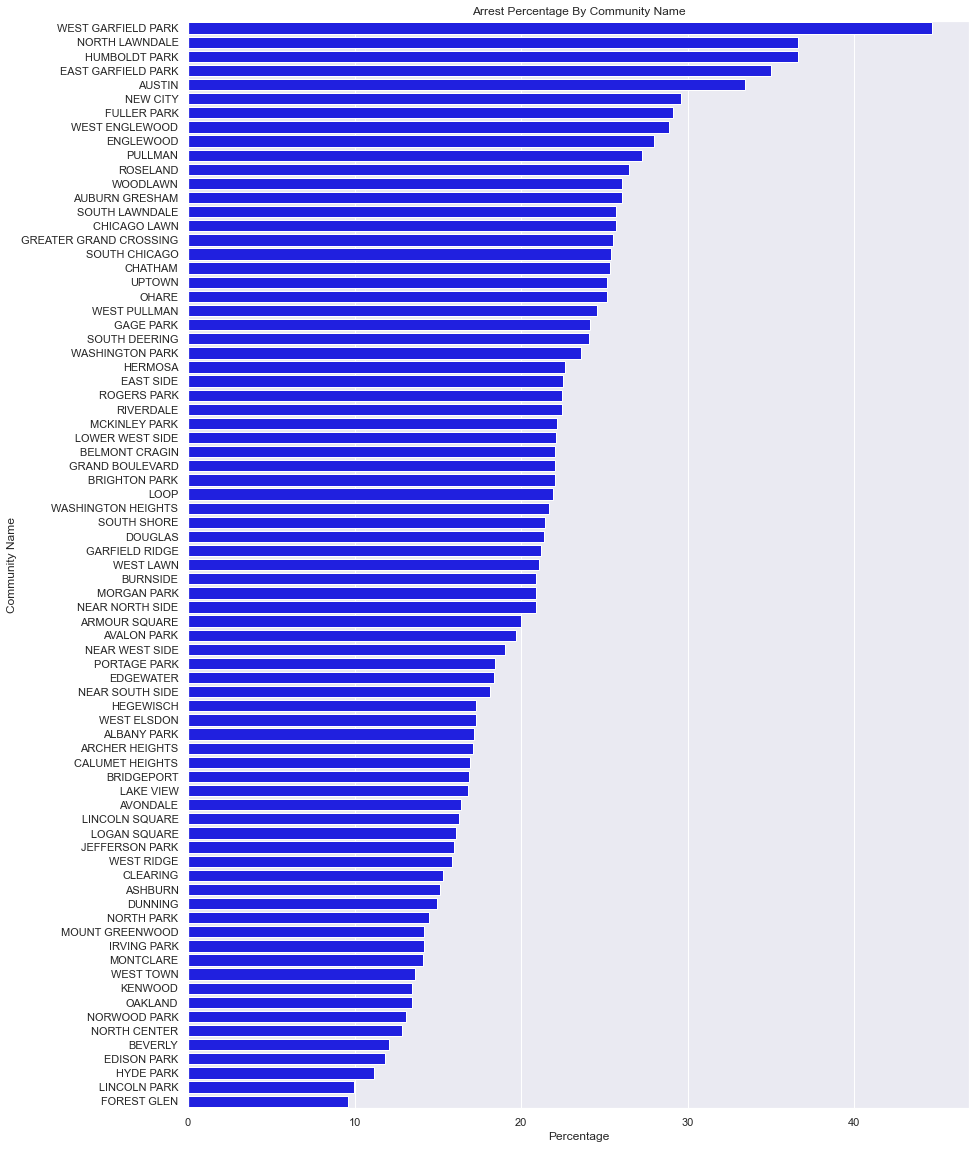

In [48]:
sns.set(rc = {'figure.figsize':(14,20)})
sns.barplot(x="mean", y = "community_name", order = comm_grp["community_name"] \
                                            , data = comm_grp, color = "blue")
plt.title("Arrest Percentage By Community Name")
plt.ylabel("Community Name")
plt.xlabel("Percentage")

## Domestic 

### Percentage of Domestic Crimes Contributing to Arrests

In [49]:
#Create boolean for only incidents that resulted in an arrest
mask = chicago_train["arrest"] == True

#Ceate a the percentages of crimes based on the filtered data set
dm_by_arrest = chicago_train.loc[mask, "domestic"].value_counts() / chicago_train[mask].shape[0] * 100

#Put the result into a data set
dm_by_arrest = pd.DataFrame(dm_by_arrest).reset_index().rename(columns ={"index": "Domestic", "domestic" : "Percentage"})
dm_by_arrest["Domestic"] = dm_by_arrest["Domestic"].astype(str)
dm_by_arrest

Domestic  Percentage
0    False   87.991094
1     True   12.008906

Text(0.5, 0, 'Percentage')

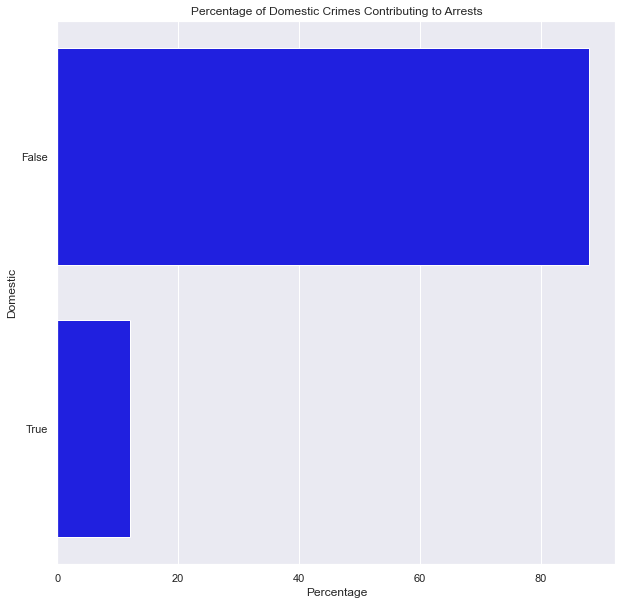

In [50]:
sns.set(rc = {'figure.figsize':(10,10)})
sns.barplot(x="Percentage", y = "Domestic", order = dm_by_arrest["Domestic"] \
                                            , data = dm_by_arrest, color = "blue")
plt.title("Percentage of Domestic Crimes Contributing to Arrests")
plt.ylabel("Domestic")
plt.xlabel("Percentage")

Nearly all the incidents were classified as non-domestic. 

### Arrest Percentage By Domestic

In [51]:
#Group by Domestic while summarizing Arrest
dom_grp = chicago_train.groupby("domestic")["arrest"].aggregate(["mean", "sum"]).sort_values(by="mean", ascending = False)
dom_grp = dom_grp.reset_index()
#Change to percentage
dom_grp["mean"] *= 100
dom_grp

domestic       mean     sum
0     False  24.900203  591587
1      True  18.399787   80739

Text(0.5, 0, 'Domestic')

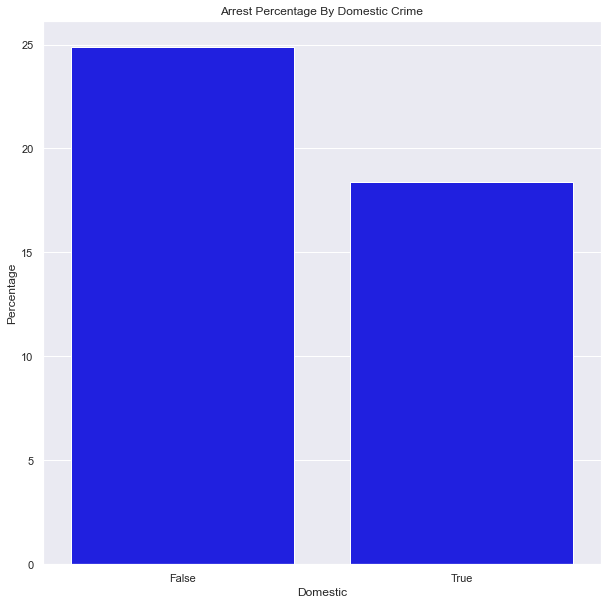

In [52]:
sns.set(rc = {'figure.figsize':(10,10)})
sns.barplot(x="domestic", y = "mean", order = dom_grp["domestic"] \
                                            , data = dom_grp, color = "blue")
plt.title("Arrest Percentage By Domestic Crime")
plt.ylabel("Percentage")
plt.xlabel("Domestic")

The difference in arrest percentage between the two is not drastic. 